# **Đề tài: Phân tích, thống kê video thịnh hành trên Youtube**


# 1. Thu thập dữ liệu

## 1.1 Đặt vấn đề
## **Trần Phan Minh Tiến**

    Question 1: Vẽ biểu đồ tròn thể hiện tỷ lệ số lượng video thịnh hành tại 10 quốc gia:
    Hoa Kỳ (US), Canada (CA), Đức (DE), Pháp (FR), Anh (GB), Ấn Độ (IN), Nhật Bản (JP), Hàn Quốc (KR), Mexico (MX), Nga (RU).

    Question 2: Vẽ biểu đồ cột so sánh lượt thích, không thích, lượt xem và bình luận trung bình của các video thịnh hành.
## **Trần Minh Thuận**

    Question 3: Top 7 kênh YouTube có số lượng video thịnh hành nhiều nhất trên toàn cầu

    Question 4: Biểu đồ thể hiện thể loại nội dung trending cho từng quốc gia
## **Hoàng Văn Đức**

    Question 5: Vẽ biểu đồ cột thể hiện số lượng video thịnh hành theo giờ đăng trong ngày
    
    Question 6: Vẽ biểu đồ đường hoặc cột thể hiện lượt xem trung bình theo từng ngày trong tuần

## 1.2 Import libraries:

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import warnings
import kagglehub

# TẢI DATA XUỐNG TỪ KAGGLEHUB

In [5]:
# Tai du lieu tu Kaggle
kaggle_download_path = kagglehub.dataset_download("datasnaek/youtube-new")
print("Path to dataset files:", kaggle_download_path)

Path to dataset files: /home/thuanc177/.cache/kagglehub/datasets/datasnaek/youtube-new/versions/115


In [6]:
# Hiding warnings for cleaner display
# Neu muon debug hay thu comment dong ben duoi
warnings.filterwarnings('ignore')

# cau hinh thu vien matplot
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# %matplotlib notebook

### Gán Mã màu, thuộc tính cho đồ thị

In [7]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sb.set_theme(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='DejaVu Sans', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

### Đọc tất cả các file

In [8]:
def read_and_fix_csv(path, fix_columns=None, default_encoding='utf-8', fallback_encoding='ISO-8859-1'):
    """
    Đọc CSV với kiểm tra encoding, và sửa lỗi encoding ở một số cột nếu cần.
    """
    try:
        df = pd.read_csv(path, encoding=default_encoding)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding=fallback_encoding)

    if fix_columns:
        for col in fix_columns:
            if col in df.columns:
                df[col] = df[col].apply(fix_encoding)

    return df

def fix_encoding(s):
    try:
        return s.encode('latin1').decode('utf-8')
    except:
        return s  # giữ nguyên nếu không chuyển được


In [9]:
country_codes = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
columns_to_fix = ['title', 'channel_title', 'description', 'tags']

# Tạo dict lưu các DataFrame
dataframes = {}

for code in country_codes:
    filepath = f"{kaggle_download_path}/{code}videos.csv"
    df = read_and_fix_csv(filepath, fix_columns=columns_to_fix)
    dataframes[code] = df

### Đọc 25 dòng đầu và cuối của tập dữ liệu

In [10]:
df.sample(25)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
8091,XRYsMNpcRxI,17.24.12,ЛУЧШИЕ ПРИКОЛЫ 2017 ДЕКАБРЬ — Сказочный патриот,Корпорация Зла,24,2017-12-23T13:28:28.000Z,"Вирусные|""видео""|""приколы""|""прикол""|""приколы 2...",97039,3985,203,103,https://i.ytimg.com/vi/XRYsMNpcRxI/default.jpg,False,False,False,Мы публикуем самые смешные и интересные видео ...
9979,#NAME?,18.02.01,Пранкеры разыграли Порошенко в новогоднюю ночь...,First,22,2018-01-01T13:43:59.000Z,генеральным секретарем НАТО Йенсом Столтенберг...,3227,14,4,3,https://i.ytimg.com/vi/-rkoQFg1Oec/default.jpg,False,False,False,Пранкеры Вован и Лексус разыграли президента У...
1612,2aiTriLB-mY,17.22.11,ЦЕНА ОШИБКИ - 2.500.000р! Купил автомобиль не ...,Максим Шелков,2,2017-11-21T15:11:15.000Z,"автокриминалист|""автохлам""|""Максим Шелков""|""ав...",392713,25144,437,2362,https://i.ytimg.com/vi/2aiTriLB-mY/default.jpg,False,False,False,Залет при покупке автомобиля без проверки! \n\...
28497,2Jri5Fd1W_Q,18.07.04,Как преодолеть зависимость? Садхгуру,Садхгуру — официальный канал на русском,22,2018-04-06T15:30:00.000Z,"Sadhguru|""Jaggi Vasudev""|""Садхгуру""|""Садгуру""|...",9719,645,19,43,https://i.ytimg.com/vi/2Jri5Fd1W_Q/default.jpg,False,False,False,"Встреча, общение, медитация с Садхгуру в Москв..."
3153,a8qFvPV4XeM,17.29.11,Вопрос-Ответ Пякин В. В. от 27 ноября 2017 г.,Фонд Концептуальных Технологий,25,2017-11-28T18:36:05.000Z,"Политика|""Путин""",31204,1249,32,253,https://i.ytimg.com/vi/a8qFvPV4XeM/default.jpg,False,False,False,Рубрика «Вопрос-Ответ» (https://fct-altai.ru/q...
6332,EraQ6Znq3YU,17.15.12,Нелегал на пресс-конференции Путина * Большая ...,Вести FM,25,2017-12-14T12:41:30.000Z,"Вести ФМ|""онлайн""|""Вести ФМ онлайн""|""live""|""Пр...",39629,465,24,84,https://i.ytimg.com/vi/EraQ6Znq3YU/default.jpg,False,False,False,Владимир Путин проводит 13-ю по счёту традицио...
12589,aYXClAOCe_U,18.17.01,Пресс-конференция П.Н. Грудинина (Полная верси...,Павел Грудинин,22,2018-01-16T17:54:40.000Z,"Грудинин|""Грудинин2018""|""НПСР""",14246,1340,34,490,https://i.ytimg.com/vi/aYXClAOCe_U/default.jpg,False,False,False,Пресс-конференция П.Н. Грудинина (Полная верси...
9832,kN7S3pNKh4U,18.02.01,Россияда Янги Йил Арчаси - Ёниб Кетти! 2018 1-...,ERKAKLAR MAKONI,22,2018-01-01T16:27:47.000Z,"uzboom tv|""nimagap""|""zor tv""|""moskva ovozi""|""r...",54219,389,39,78,https://i.ytimg.com/vi/kN7S3pNKh4U/default.jpg,False,False,False,АГАР СИЗ БИЗНИНГ КАНАЛИМИЗДА БИРИНЧИ БУЛСАНГИЗ...
37076,Hm0m42XA8cs,18.27.05,17 ЛЕГКИХ СОВЕТОВ И ТРЮКОВ ПО РИСОВАНИЮ ДЛЯ НА...,БЕРИ И ДЕЛАЙ,26,2018-05-26T20:48:29.000Z,"Сделай сам|""лайфхаки""|""поделки""|""бери и делай""...",29495,1624,103,201,https://i.ytimg.com/vi/Hm0m42XA8cs/default.jpg,False,False,False,"На этот раз, я покажу вам, как рисовать животн..."
22964,yof_rbxu8Nc,18.11.03,МИТИНГ В ПОДДЕРЖКУ ГРУДИНИНА В МОСКВЕ 10.03.2018,Антиплатон,25,2018-03-10T15:45:59.000Z,"Павел Грудинин|""Политика""|""митинг""|""Москва""|""в...",521274,0,0,8612,https://i.ytimg.com/vi/yof_rbxu8Nc/default.jpg,False,True,False,Митинг в поддержку Грудинина в Москве\nКрасная...


## 1.3 Xem thông tin của Dataset

### VIẾT HÀM HIỂN THỊ THÔNG TIN CƠ BẢN CHO TỪNG DỮ LIỆU CỦA TỪNG QUỐC GIA

In [11]:
def display_basic_info(dataframes, country_names):
    """
    Hiển thị thông tin tổng quan và chi tiết về dữ liệu từng quốc gia.
    """
    print("\n=== 📊 THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===")

    total_records = 0
    for country, df in dataframes.items():
        print(f"\n{country_names.get(country, 'Unknown')} ({country}):")
        print(f"  - 📄 Số bản ghi: {len(df):,}")
        print(f"  - 🧱 Số cột: {len(df.columns)}")
        print(f"  - 💾 Kích thước bộ nhớ: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

        # Video duy nhất
        unique_videos = df['video_id'].nunique() if 'video_id' in df.columns else 'N/A'
        print(f"  - 🎥 Video duy nhất: {unique_videos:,}")

        # Category phổ biến
        if 'category_id' in df.columns:
            top_categories = df['category_id'].value_counts().head(3).to_dict()
            print(f"  - 🔢 Top 3 category_id: {top_categories}")

        # Mô tả bị thiếu (NaN hoặc rỗng)
        missing_descriptions = df['description'].isna().sum() if 'description' in df.columns else 0
        empty_descriptions = (df['description'] == '').sum() if 'description' in df.columns else 0
        total_missing = missing_descriptions + empty_descriptions
        if 'description' in df.columns:
            missing_rate = total_missing / len(df) * 100
            print(f"  - 📝 Mô tả thiếu (NaN + rỗng): {total_missing:,} ({missing_rate:.2f}%)")

        # Ngày xuất bản sớm nhất & muộn nhất
        if 'publish_time' in df.columns:
            try:
                df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
                min_date = df['publish_time'].min()
                max_date = df['publish_time'].max()
                print(f"  - 📆 Ngày đăng: {min_date.date()} ➝ {max_date.date()}")
            except Exception as e:
                print(f"  - ⚠️ Lỗi chuyển đổi ngày: {e}")

        # Cột có dữ liệu thiếu
        null_columns = df.columns[df.isnull().any()]
        if len(null_columns):
            print(f"  - ⚠️ Các cột có missing values: {', '.join(null_columns)}")

        total_records += len(df)

    print(f"\n📈 TỔNG KẾT:")
    print(f"  - Tổng số bản ghi: {total_records:,}")
    print(f"  - Số quốc gia: {len(dataframes)}")


### GÁN NHÃN TÊN CHO CÁC MÃ QUỐC GIA

In [12]:
country_names = {
    'US': 'United States',
    'CA': 'Canada',
    'DE': 'Germany',
    'FR': 'France',
    'GB': 'United Kingdom',
    'IN': 'India',
    'JP': 'Japan',
    'KR': 'South Korea',
    'MX': 'Mexico',
    'RU': 'Russia'
}


### GỌI HÀM HIỂN THỊ THÔNG TIN DỮ LIỆU

In [13]:
display_basic_info(dataframes, country_names)


=== 📊 THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===

United States (US):
  - 📄 Số bản ghi: 40,949
  - 🧱 Số cột: 16
  - 💾 Kích thước bộ nhớ: 109.6 MB
  - 🎥 Video duy nhất: 6,351
  - 🔢 Top 3 category_id: {24: 9964, 10: 6472, 26: 4146}
  - 📝 Mô tả thiếu (NaN + rỗng): 570 (1.39%)
  - 📆 Ngày đăng: 2006-07-23 ➝ 2018-06-14
  - ⚠️ Các cột có missing values: description

Canada (CA):
  - 📄 Số bản ghi: 40,881
  - 🧱 Số cột: 16
  - 💾 Kích thước bộ nhớ: 109.8 MB
  - 🎥 Video duy nhất: 24,427
  - 🔢 Top 3 category_id: {24: 13451, 25: 4159, 22: 4105}
  - 📝 Mô tả thiếu (NaN + rỗng): 1,296 (3.17%)
  - 📆 Ngày đăng: 2008-01-13 ➝ 2018-06-14
  - ⚠️ Các cột có missing values: description

Germany (DE):
  - 📄 Số bản ghi: 40,840
  - 🧱 Số cột: 16
  - 💾 Kích thước bộ nhớ: 114.2 MB
  - 🎥 Video duy nhất: 29,627
  - 🔢 Top 3 category_id: {24: 15292, 22: 5988, 25: 2935}
  - 📝 Mô tả thiếu (NaN + rỗng): 1,552 (3.80%)
  - 📆 Ngày đăng: 2012-04-18 ➝ 2018-06-14
  - ⚠️ Các cột có missing values: description

France (FR):
  - 📄 Số bản ghi

# 2. Truy cập vào dữ liệu:

---



In [14]:
def thong_ke_du_lieu(df, country_names):
    print("\n[KHÁM PHÁ DỮ LIỆU]")
    print("=" * 40)

    for code, table in df.items():
        print(f"\nQuốc gia: {country_names[code]} - Mã: {code}")
        print("-" * 40)

        print(f"Tổng số dòng: {len(table)}, số cột: {len(table.columns)}")
        print(f"Kích thước bộ nhớ: {table.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        print("\nCột và kiểu dữ liệu:")
        for column in table.columns:
            nulls = table[column].isna().sum()
            print(f"{column}: {table[column].dtype}, null: {nulls}")

        print("\nMột số dòng đầu tiên:")
        if all(c in table.columns for c in ['title', 'channel_title', 'views']):
            print(table[['title', 'channel_title', 'views']].head())
        else:
            print("Không thể hiển thị vì thiếu cột.")

        print("\nThống kê số liệu:")
        number_col = ['views', 'likes', 'dislikes', 'comment_count']
        number_col = [c for c in number_col if c in table.columns]
        if number_col:
            print(table[number_col].describe().round(1))
        else:
            print("Không có cột số để thống kê.")

        print("\nKiểm tra missing values:")
        missing = table.isna().sum()
        for column, sl in missing.items():
            if sl > 0:
                print(f"{column}: {sl} ({sl/len(table)*100:.1f}%)")

        print("-" * 40)


In [15]:
thong_ke_du_lieu(dataframes, country_names)


[KHÁM PHÁ DỮ LIỆU]

Quốc gia: United States - Mã: US
----------------------------------------
Tổng số dòng: 40949, số cột: 16
Kích thước bộ nhớ: 107.03 MB

Cột và kiểu dữ liệu:
video_id: object, null: 0
trending_date: object, null: 0
title: object, null: 0
channel_title: object, null: 0
category_id: int64, null: 0
publish_time: datetime64[ns, UTC], null: 0
tags: object, null: 0
views: int64, null: 0
likes: int64, null: 0
dislikes: int64, null: 0
comment_count: int64, null: 0
thumbnail_link: object, null: 0
comments_disabled: bool, null: 0
ratings_disabled: bool, null: 0
video_error_or_removed: bool, null: 0
description: object, null: 570

Một số dòng đầu tiên:
                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3             

## 2.1 Thêm cột

# Thêm các cột phân tích hiệu suất vào DataFrame.

Thêm các cột:
        - engagement_rate (%)
        - like_dislike_ratio
        - viral_score
        - performance_category

In [16]:
def add_performance_metrics(df):
    """
    
    """
    if df is None or df.empty:
        print("⚠️ DataFrame rỗng hoặc không hợp lệ.")
        return df

    print("🚀 Thêm cột phân tích hiệu suất...")

    df = df.copy()

    # Engagement Rate (%)
    df['engagement_rate'] = ((df['likes'] + df['comment_count']) / df['views'].replace(0, np.nan) * 100).round(2)
    df['engagement_rate'] = df['engagement_rate'].fillna(0).clip(lower=0)

    # Like/Dislike Ratio
    df['like_dislike_ratio'] = np.where(
        df['dislikes'] > 0,
        (df['likes'] / df['dislikes']).round(2),
        np.where(df['likes'] > 0, np.inf, 0)
    )

    # Viral Score
    max_views = df['views'].max() or 1
    max_engagement = df['engagement_rate'].max() or 1

    df['viral_score'] = (
        (df['views'] / max_views * 0.7 +
         df['engagement_rate'] / max_engagement * 0.3) * 100
    ).round(2)

    # Performance Category
    df['performance_category'] = pd.cut(
        df['viral_score'],
        bins=[0, 20, 40, 60, 80, 100],
        labels=['Low', 'Below Average', 'Average', 'Good', 'Excellent'],
        include_lowest=True
    )

    print("✅ Đã thêm: engagement_rate, like_dislike_ratio, viral_score, performance_category")
    return df

# 3. Làm sạch dữ liệu

## 3.1. Các bước làm sạch dữ liệu chi tiết

Để đảm bảo chất lượng dữ liệu cho phân tích, chúng ta sẽ thực hiện các bước làm sạch sau cho DataFrame của mỗi quốc gia:

1.  **Kiểm tra tính đầy đủ (Completeness):**
    *   Mục tiêu: Đảm bảo các cột quan trọng không chứa giá trị thiếu (null).
    *   Các cột mục tiêu: `video_id`, `title` (tên video), `channel_title` (tên kênh), và `trending_date` (ngày trending).
    *   Hành động: Loại bỏ các hàng (dòng) có bất kỳ giá trị null nào trong các cột này.

2.  **Kiểm tra tính duy nhất (Uniqueness):**
    *   Mục tiêu: Đảm bảo mỗi video (`video_id`) là duy nhất trong bộ dữ liệu của mỗi quốc gia.
    *   Hành động: Loại bỏ các hàng có `video_id` trùng lặp, chỉ giữ lại bản ghi đầu tiên xuất hiện.

3.  **Kiểm tra tính nhất quán (Consistency):**
    *   Mục tiêu: Đảm bảo dữ liệu tuân theo định dạng và kiểu dữ liệu mong muốn.
    *   **Ngày tháng:** Kiểm tra cột `trending_date` có thống nhất theo định dạng `yy.dd.mm` (năm.ngày.tháng). Chuyển đổi sang kiểu dữ liệu datetime. Những hàng không đúng định dạng sẽ bị loại bỏ.
    *   **Kiểu dữ liệu số:** Kiểm tra các cột `views` (lượt xem), `likes` (lượt thích), `dislikes` (lượt không thích), `comment_count` (số bình luận) có phải là kiểu số nguyên. Những hàng có giá trị không phải số trong các cột này sẽ được loại bỏ, sau đó các cột này sẽ được chuyển đổi sang kiểu số nguyên.

In [17]:
def clean_completeness(df, country_code):
    """
    Kiểm tra và đảm bảo tính đầy đủ của các cột thiết yếu.
    Loại bỏ các hàng có giá trị null trong các cột: video_id, title, channel_title, trending_date.
    """
    print(f"  Kiểm tra tính đầy đủ (Completeness) cho {country_code}:")
    initial_rows = len(df)
    essential_columns = ['video_id', 'title', 'channel_title', 'trending_date']
    
    # Kiểm tra xem các cột thiết yếu có tồn tại trong DataFrame không
    existing_essential_columns = [col for col in essential_columns if col in df.columns]
    
    if not existing_essential_columns:
        print(f"    ⚠️  Cảnh báo: Không có cột thiết yếu nào ({', '.join(essential_columns)}) để kiểm tra tính đầy đủ cho {country_code}. Bỏ qua.")
        return df

    # In ra những cột thiết yếu không có mặt (nếu có)
    missing_cols_in_check = [col for col in essential_columns if col not in existing_essential_columns]
    if missing_cols_in_check:
        print(f"    ⚠️  Lưu ý: Các cột sau không có trong DataFrame và sẽ không được kiểm tra tính đầy đủ: {', '.join(missing_cols_in_check)}")

    df_cleaned = df.dropna(subset=existing_essential_columns)
    rows_removed = initial_rows - len(df_cleaned)
    print(f"    - Số hàng ban đầu: {initial_rows}")
    print(f"    - Số hàng bị loại bỏ do thiếu giá trị trong ({', '.join(existing_essential_columns)}): {rows_removed}")
    print(f"    - Số hàng còn lại: {len(df_cleaned)}")
    return df_cleaned

def add_missing_values(df, country_code):
    """
    Thêm các giá trị mặc định cho các cột có thể thiếu.
    - Thêm 'No description' description.
    - Thêm 0 cho các cột số liệu nếu bị thiếu.
    """
    print(f"  Thêm giá trị mặc định cho các cột có thể thiếu cho {country_code}:")
    
    # Kiểm tra và thêm giá trị mặc định cho cột 'description'
    if 'description' in df.columns:
        missing_desc_count = df['description'].isna().sum()
        if missing_desc_count > 0:
            df['description'] = df['description'].fillna('No description')
            print(f"    - Đã thêm 'No description' cho {missing_desc_count} hàng thiếu mô tả.")
    else:
        print("    ⚠️  Cảnh báo: Cột 'description' không tìm thấy trong DataFrame của {country_code}. Bỏ qua bước này.")

    # Kiểm tra và thêm giá trị 0 cho các cột số liệu
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numeric_cols:
        if col in df.columns:
            missing_numeric_count = df[col].isna().sum()
            if missing_numeric_count > 0:
                df[col] = df[col].fillna(0)
                print(f"    - Đã thêm 0 cho {missing_numeric_count} hàng thiếu trong cột '{col}'.")
        else:
            print(f"    ⚠️  Cảnh báo: Cột '{col}' không tìm thấy trong DataFrame của {country_code}. Bỏ qua bước này.")

    return df

def clean_uniqueness(df, country_code):
    """
    Kiểm tra và đảm bảo tính duy nhất của video_id.
    Loại bỏ các hàng có video_id trùng lặp, giữ lại bản ghi đầu tiên.
    """
    print(f"  Kiểm tra tính duy nhất (Uniqueness) của video_id cho {country_code}:")
    initial_rows = len(df)
    if 'video_id' not in df.columns:
        print(f"    ⚠️  Cảnh báo: Cột 'video_id' không tìm thấy trong DataFrame của {country_code}. Bỏ qua bước kiểm tra tính duy nhất.")
        return df
        
    df_cleaned = df.drop_duplicates(subset=['video_id'], keep='first')
    rows_removed = initial_rows - len(df_cleaned)
    print(f"    - Số hàng ban đầu: {initial_rows}")
    print(f"    - Số hàng bị loại bỏ do video_id trùng lặp: {rows_removed}")
    print(f"    - Số hàng còn lại: {len(df_cleaned)}")
    return df_cleaned

def clean_consistency(df, country_code):
    """
    Kiểm tra và đảm bảo tính nhất quán của dữ liệu ngày tháng và kiểu số.
    - Chuyển đổi 'trending_date' sang datetime (format yy.dd.mm), loại bỏ nếu lỗi.
    - Chuyển đổi các cột số liệu sang kiểu số nguyên, loại bỏ nếu lỗi.
    """
    print(f"  Kiểm tra tính nhất quán (Consistency) cho {country_code}:")
    initial_rows = len(df)
    df_cleaned = df.copy()

    # 1. Tính nhất quán ngày tháng cho 'trending_date'
    if 'trending_date' in df_cleaned.columns:
        original_trending_date_count = len(df_cleaned)
        df_cleaned['trending_date'] = pd.to_datetime(df_cleaned['trending_date'], format='%y.%d.%m', errors='coerce')
        # Đếm số lượng NaT trước khi drop để biết bao nhiêu dòng bị ảnh hưởng bởi format
        invalid_date_format_count = df_cleaned['trending_date'].isnull().sum()
        df_cleaned.dropna(subset=['trending_date'], inplace=True) # Loại bỏ các hàng có NaT
        if invalid_date_format_count > 0:
            print(f"    - Định dạng ngày 'trending_date': {invalid_date_format_count} hàng bị loại bỏ do định dạng ngày không hợp lệ ('%y.%d.%m') hoặc thiếu.")
    else:
        print("    ⚠️  Cảnh báo: Cột 'trending_date' không tìm thấy. Bỏ qua kiểm tra định dạng ngày.")

    # 2. Tính nhất quán kiểu dữ liệu số
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numeric_cols:
        if col in df_cleaned.columns:
            # Đếm số lượng giá trị không phải số trước khi chuyển đổi và drop
            # Tạm thời chuyển sang string để kiểm tra isdigit nếu cần thiết, hoặc dựa vào pd.to_numeric
            non_numeric_count_before = len(df_cleaned)
            
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
            invalid_numeric_count = df_cleaned[col].isnull().sum() # Số lượng giá trị không thể chuyển đổi thành số
            
            df_cleaned.dropna(subset=[col], inplace=True) # Loại bỏ các hàng có NaN sau khi coerce
            
            if invalid_numeric_count > 0:
                 print(f"    - Kiểu dữ liệu cột '{col}': {invalid_numeric_count} hàng bị loại bỏ do giá trị không phải số hoặc thiếu.")
            
            # Chuyển sang Int64 để hỗ trợ số nguyên (nếu không còn NaN)
            # Nếu cột vẫn còn giá trị (không phải tất cả đều bị drop), thì chuyển kiểu
            if not df_cleaned.empty and col in df_cleaned.columns:
                 df_cleaned[col] = df_cleaned[col].astype('Int64')
        else:
            print(f"    ⚠️  Cảnh báo: Cột '{col}' không tìm thấy. Bỏ qua kiểm tra kiểu dữ liệu số cho cột này.")
            
    total_rows_after_consistency = len(df_cleaned)
    # rows_removed_total_consistency = initial_rows - total_rows_after_consistency (Tính toán này không chính xác nếu các bước drop chồng chéo)
    print(f"    - Số hàng ban đầu (trước kiểm tra nhất quán): {initial_rows}")
    # print(f"    - Tổng số hàng bị loại bỏ trong bước kiểm tra nhất quán: {rows_removed_total_consistency}") # Có thể gây nhầm lẫn
    print(f"    - Số hàng còn lại sau kiểm tra nhất quán: {total_rows_after_consistency}")
    return df_cleaned

In [18]:
def clean_all_dataframes(dataframes_dict, country_names_map):
    """
    Áp dụng tất cả các bước làm sạch cho mỗi DataFrame trong dictionary.
    Cập nhật dictionary `dataframes_dict` tại chỗ.
    """
    print("🚀 BẮT ĐẦU QUÁ TRÌNH LÀM SẠCH DỮ LIỆU CHO TẤT CẢ CÁC QUỐC GIA 🚀")
    
    for country_code in list(dataframes_dict.keys()): # list() để tránh lỗi thay đổi dict khi lặp
        df = dataframes_dict[country_code]
        country_name = country_names_map.get(country_code, country_code)
        print(f"\n--- Đang xử lý: {country_name} ({country_code}) ---")
        initial_total_rows = len(df)
        print(f"  Số hàng ban đầu tổng cộng: {initial_total_rows}")

        if initial_total_rows == 0:
            print(f"    DataFrame cho {country_name} ({country_code}) rỗng. Bỏ qua làm sạch.")
            continue

        df_temp = clean_completeness(df.copy(), country_code) # .copy() để tránh SettingWithCopyWarning
        if not df_temp.empty:
            df_temp = clean_uniqueness(df_temp, country_code)
        if not df_temp.empty:
            df_temp = clean_consistency(df_temp, country_code)
        if not df_temp.empty:
            df_temp = add_missing_values(df_temp, country_code)
        
        dataframes_dict[country_code] = df_temp # Cập nhật trực tiếp dict gốc
        
        final_total_rows = len(df_temp)
        total_rows_removed_for_country = initial_total_rows - final_total_rows
        
        print(f"  --- Hoàn tất xử lý cho {country_name} ({country_code}) ---")
        print(f"    Số hàng ban đầu: {initial_total_rows}")
        print(f"    Số hàng còn lại sau khi làm sạch: {final_total_rows}")
        print(f"    Tổng số hàng đã loại bỏ: {total_rows_removed_for_country}")
        if initial_total_rows > 0:
            print(f"    Tỷ lệ dữ liệu còn lại: {final_total_rows / initial_total_rows * 100:.2f}%")
        else:
            print(f"    Tỷ lệ dữ liệu còn lại: N/A (không có dữ liệu ban đầu)")

    print("\n✅ HOÀN TẤT QUÁ TRÌNH LÀM SẠCH DỮ LIỆU CHO TẤT CẢ CÁC QUỐC GIA ✅")


### Gọi hàm làm sạch dữ liệu

Bây giờ, chúng ta sẽ gọi hàm `clean_all_dataframes` để áp dụng các bước làm sạch đã định nghĩa ở trên cho tất cả các DataFrame của từng quốc gia. Biến `dataframes` (là một dictionary chứa các DataFrame) sẽ được cập nhật trực tiếp với các DataFrame đã được làm sạch.

In [19]:
# Gọi hàm làm sạch dữ liệu
# Biến 'dataframes' sẽ được cập nhật tại chỗ với các DataFrame đã được làm sạch.
# Biến 'country_names' được giả định là đã tồn tại từ các ô trước.

if 'dataframes' in globals() and isinstance(dataframes, dict) and 'country_names' in globals() and isinstance(country_names, dict):
    print("Đang tiến hành làm sạch dữ liệu...")
    # Hàm clean_all_dataframes sẽ sửa đổi 'dataframes' dict trực tiếp.
    clean_all_dataframes(dataframes, country_names) 
    
    print("\nKiểm tra lại số lượng bản ghi sau khi làm sạch:")
    total_records_after_cleaning = 0
    for code, df_cleaned in dataframes.items():
        country_name = country_names.get(code, code)
        count = len(df_cleaned)
        print(f"  - {country_name} ({code}): {count:,} bản ghi")
        total_records_after_cleaning += count
    print(f"Tổng số bản ghi trên tất cả các quốc gia sau khi làm sạch: {total_records_after_cleaning:,}")
else:
    print("⚠️ Lỗi: Biến 'dataframes' (dictionary) hoặc 'country_names' (dictionary) chưa được định nghĩa hoặc không đúng kiểu. \nHãy đảm bảo chúng đã được tải và xử lý ở các ô trước khi chạy ô này.")


Đang tiến hành làm sạch dữ liệu...
🚀 BẮT ĐẦU QUÁ TRÌNH LÀM SẠCH DỮ LIỆU CHO TẤT CẢ CÁC QUỐC GIA 🚀

--- Đang xử lý: United States (US) ---
  Số hàng ban đầu tổng cộng: 40949
  Kiểm tra tính đầy đủ (Completeness) cho US:


    - Số hàng ban đầu: 40949
    - Số hàng bị loại bỏ do thiếu giá trị trong (video_id, title, channel_title, trending_date): 0
    - Số hàng còn lại: 40949
  Kiểm tra tính duy nhất (Uniqueness) của video_id cho US:
    - Số hàng ban đầu: 40949
    - Số hàng bị loại bỏ do video_id trùng lặp: 34598
    - Số hàng còn lại: 6351
  Kiểm tra tính nhất quán (Consistency) cho US:
    - Số hàng ban đầu (trước kiểm tra nhất quán): 6351
    - Số hàng còn lại sau kiểm tra nhất quán: 6351
  Thêm giá trị mặc định cho các cột có thể thiếu cho US:
    - Đã thêm 'No description' cho 102 hàng thiếu mô tả.
  --- Hoàn tất xử lý cho United States (US) ---
    Số hàng ban đầu: 40949
    Số hàng còn lại sau khi làm sạch: 6351
    Tổng số hàng đã loại bỏ: 34598
    Tỷ lệ dữ liệu còn lại: 15.51%

--- Đang xử lý: Canada (CA) ---
  Số hàng ban đầu tổng cộng: 40881
  Kiểm tra tính đầy đủ (Completeness) cho CA:
    - Số hàng ban đầu: 40881
    - Số hàng bị loại bỏ do thiếu giá trị trong (video_id, title, channel_t

## 3.2. Làm giàu dữ liệu

### Thêm mã quốc gia trước khi merge data set

In [20]:
def add_country_code_to_dataframes(dataframes_dict):
    """
    Thêm cột 'country_code' vào mỗi DataFrame trong dictionary trước khi merge.
    """
    print("🔧 THÊM CỘT COUNTRY_CODE VÀO CÁC DATAFRAMES")
    print("=" * 50)
    
    for country_code, df in dataframes_dict.items():
        # Thêm cột country_code
        df['country_code'] = country_code
        
        # Thêm cột country_name sử dụng mapping đã có
        df['country_name'] = country_names.get(country_code, country_code)
        
        print(f"✓ Đã thêm country_code '{country_code}' và country_name cho {len(df):,} bản ghi")
    
    print("\n✅ HOÀN TẤT THÊM CỘT COUNTRY_CODE CHO TẤT CẢ DATAFRAMES")
    return dataframes_dict

# Gọi hàm để thêm country_code vào các dataframes
dataframes = add_country_code_to_dataframes(dataframes)

🔧 THÊM CỘT COUNTRY_CODE VÀO CÁC DATAFRAMES
✓ Đã thêm country_code 'US' và country_name cho 6,351 bản ghi
✓ Đã thêm country_code 'CA' và country_name cho 24,427 bản ghi
✓ Đã thêm country_code 'DE' và country_name cho 29,627 bản ghi
✓ Đã thêm country_code 'FR' và country_name cho 30,581 bản ghi
✓ Đã thêm country_code 'GB' và country_name cho 3,272 bản ghi
✓ Đã thêm country_code 'IN' và country_name cho 16,307 bản ghi
✓ Đã thêm country_code 'JP' và country_name cho 12,912 bản ghi
✓ Đã thêm country_code 'KR' và country_name cho 15,876 bản ghi
✓ Đã thêm country_code 'MX' và country_name cho 33,513 bản ghi
✓ Đã thêm country_code 'RU' và country_name cho 34,282 bản ghi

✅ HOÀN TẤT THÊM CỘT COUNTRY_CODE CHO TẤT CẢ DATAFRAMES


### TẠO DATASET TỔNG HỢP (MERGE)

In [21]:
def create_combined_dataset(dataframes):
    """
    Tạo dataset tổng hợp từ tất cả các quốc gia.
    """
    print("\n=== 🔄 TẠO DATASET TỔNG HỢP ===")

    # Kết hợp tất cả DataFrame
    combined_df = pd.concat(dataframes.values(), ignore_index=True)

    print(f"📊 Số bản ghi trong dataset tổng hợp: {len(combined_df):,}")
    print(f"📋 Số cột trong dataset tổng hợp: {len(combined_df.columns)}")
    print(f"💾 Kích thước bộ nhớ: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB" )

    return combined_df


In [22]:
combined_df = create_combined_dataset(dataframes)


=== 🔄 TẠO DATASET TỔNG HỢP ===
📊 Số bản ghi trong dataset tổng hợp: 207,148
📋 Số cột trong dataset tổng hợp: 18
💾 Kích thước bộ nhớ: 493.91 MB


In [23]:
combined_df.sample(20)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country_code,country_name
47841,mTWr4Ybif0A,2018-03-13,Robert Franz:Tag der Abrechnung,Robert Franz,29,2018-03-12 11:30:56+00:00,[none],17975,1252,78,328,https://i.ytimg.com/vi/mTWr4Ybif0A/default.jpg,False,False,False,Heute Besuch bei der Ärztekammer in Graz unter...,DE,Germany
30547,FWX3xTwX6vI,2018-06-13,Crime Patrol Satark - Ep 927 - Full Episode - ...,SET India,24,2018-06-12 15:19:24+00:00,"true events|""sony entertainment channel""|""cons...",51842,282,44,59,https://i.ytimg.com/vi/FWX3xTwX6vI/default.jpg,False,False,False,Click here to subscribe to SonyLIV : http://w...,CA,Canada
186836,kk6coUfT-s8,2018-02-06,Су-25: последний бой. Время покажет. Выпуск от...,Новости на Первом Канале,25,2018-02-05 13:07:27+00:00,"Война и вооруженные конфликты|""Екатерина Стриж...",32136,275,100,0,https://i.ytimg.com/vi/kk6coUfT-s8/default.jpg,True,False,False,В Сирии сбит российский Су-25. Летчик Роман Фи...,RU,Russia
144349,FvKJrNafNG4,2017-12-14,Exatlón México | Ana Lago y Daniel Corral,Nath H,10,2017-12-12 21:18:37+00:00,"Ana lago|""Daniel corral""|""Anto gaxila""|""ciclis...",20175,77,33,22,https://i.ytimg.com/vi/FvKJrNafNG4/default.jpg,False,False,False,Exatlon México programa 43 44 45 46 47 48 49 5...,MX,Mexico
160948,v0uZLjFaPzE,2018-03-27,France vs Russia 4-2 All Goals and Extended Hi...,TehFuriousD TV,17,2018-03-26 09:00:04+00:00,"all|""goals""|""highlights""|""football""|""skills""|""...",669739,2315,730,209,https://i.ytimg.com/vi/v0uZLjFaPzE/default.jpg,False,False,False,- Various other YouTubers use videos I make (a...,MX,Mexico
69322,eENhhV5UZIw,2018-01-14,وجبة شتوية لذيذة و سريعة بمقبلات دافئة للغذاء ...,الطبخ و البيت مع انتصارIntissar's Channel,22,2018-01-13 11:00:35+00:00,"طاجين الشفلور""|""طاجين مغربي""|""طاجين الخضر""|""مق...",31535,1861,90,207,https://i.ytimg.com/vi/eENhhV5UZIw/default.jpg,False,False,False,السلام عليكم و رحمة الله و بركاته \n\nنتمنى في...,FR,France
161450,R3MO1b1axGQ,2018-03-30,♡ASMR español♡ TUS SONIDOS FAVORITOS. ♥ |cosqu...,EL ASMR,24,2018-03-29 19:30:00+00:00,"ASMR|""EL ASMR""|""ASMR español""|""TUS SONIDOS FAV...",42055,3724,64,1175,https://i.ytimg.com/vi/R3MO1b1axGQ/default.jpg,False,False,False,"Hola Hermosura! En este ASMR en español, TUS S...",MX,Mexico
75570,di0QD4ItBvk,2018-02-26,La truffe noire du Périgord - Documentaire You...,YouCook Cuisine,26,2018-02-25 10:30:00+00:00,"YouCook""|""cuisine""|""recette""|""documentaire""|""r...",46679,6114,38,551,https://i.ytimg.com/vi/di0QD4ItBvk/default.jpg,False,False,False,"Comme promis, 2018 rime avec nouveauté pour l'...",FR,France
140102,w-Ksq3W6QHg,2017-11-18,Paul Stanley Furioso con Productor que lo Hundió,Chacaleo. Com,24,2017-11-17 14:00:03+00:00,"Final programa “Buenas Vibras”|""termina progra...",112803,1183,140,300,https://i.ytimg.com/vi/w-Ksq3W6QHg/default.jpg,False,False,False,"La ilusión para Paul Stanley le duró poco, pue...",MX,Mexico
5076,JBTNG-8w5_g,2018-03-30,Conan Plays Horse With Magic Johnson - CONAN ...,Team Coco,23,2018-03-28 02:53:37+00:00,Conan O'Brien Conan Conan (TV Series) TBS (TV ...,891181,15717,171,1052,https://i.ytimg.com/vi/JBTNG-8w5_g/default.jpg,False,False,False,Conan O’Brien and NBA legend Magic Johnson wor...,US,United States


# **4. Trả lời các câu hỏi đặt ra cùng với visualizations**

##  **Trần Phan Minh Tiến**
### **Question 1**: Vẽ biểu đồ tròn thể hiện tỷ lệ số lượng video thịnh hành tại 10 quốc gia: Hoa Kỳ (US), Canada (CA), Đức (DE), Pháp (FR), Anh (GB), Ấn Độ (IN), Nhật Bản (JP), Hàn Quốc (KR), Mexico (MX), Nga (RU).


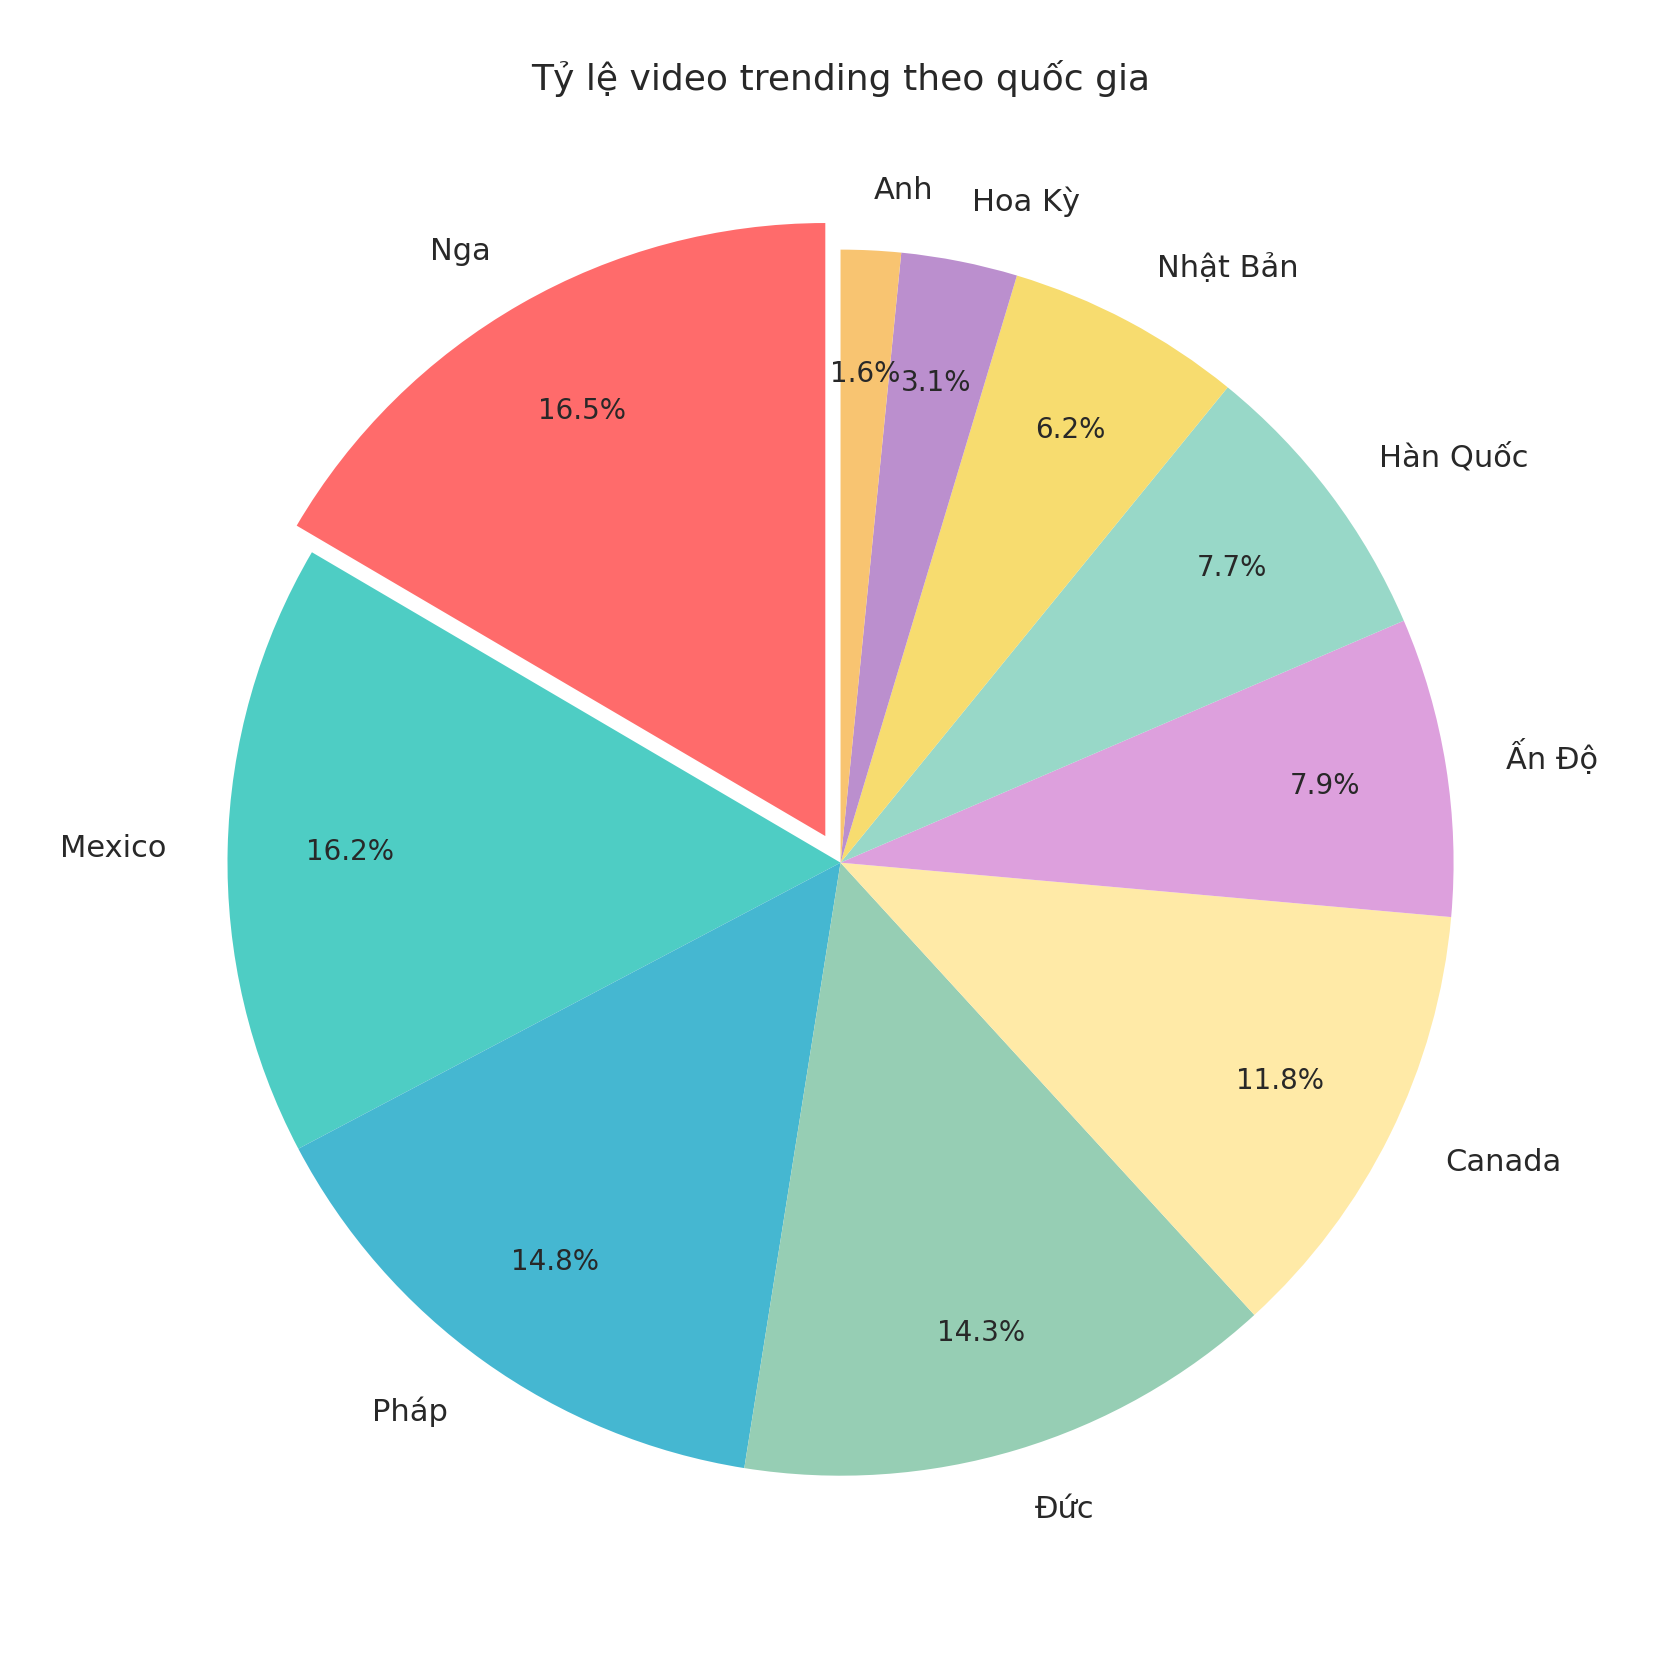

Tổng: 207,148 video

Nga: 34,282 video (16.5%)
Mexico: 33,513 video (16.2%)
Pháp: 30,581 video (14.8%)
Đức: 29,627 video (14.3%)
Canada: 24,427 video (11.8%)
Ấn Độ: 16,307 video (7.9%)
Hàn Quốc: 15,876 video (7.7%)
Nhật Bản: 12,912 video (6.2%)
Hoa Kỳ: 6,351 video (3.1%)
Anh: 3,272 video (1.6%)


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

codes = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
names = {
    'US': 'Hoa Kỳ', 'CA': 'Canada', 'DE': 'Đức', 'FR': 'Pháp',
    'GB': 'Anh', 'IN': 'Ấn Độ', 'JP': 'Nhật Bản',
    'KR': 'Hàn Quốc', 'MX': 'Mexico', 'RU': 'Nga'
}

# Lấy số lượng video mỗi nước
counts = {}
for c in codes:
    if c in dataframes:
        counts[c] = len(dataframes[c])

# Tổng tất cả video
s = sum(counts.values())

# Dữ liệu để vẽ
data = []
for c in sorted(counts, key=counts.get, reverse=True):
    data.append({
        'code': c,
        'name': names[c],
        'count': counts[c],
        'pct': counts[c] / s * 100
    })

# Đưa vào DataFrame
df = pd.DataFrame(data)

# Gán mã màu
cols = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
        '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#F8C471']

# Vẽ pie chart
plt.figure(figsize=(8, 8))
plt.pie(df['count'], 
        labels=df['name'],
        colors=cols[:len(df)],
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.8,
        explode=[0.05] + [0]* (len(df) - 1))
plt.title('Tỷ lệ video trending theo quốc gia', fontsize=13)
plt.axis('equal')
plt.tight_layout()
plt.show()

# In kết quả
print(f"Tổng: {s:,} video\n")
for row in df.itertuples():
    print(f"{row.name}: {row.count:,} video ({row.pct:.1f}%)")

## Nhận xét từ biểu đồ phân bố video trending theo quốc gia

### 1. Tổng thể xu hướng
Biểu đồ cho thấy **Nga** và **Mexico** dẫn đầu về số lượng video trending với tỷ lệ lần lượt là **16.5%** và **16.2%**. Điều này phản ánh hoạt động sôi nổi của cộng đồng người dùng và tính đa dạng của nội dung trên nền tảng YouTube tại các thị trường này.

---

### 2. Sự phân hóa rõ rệt theo quốc gia

**Nhóm dẫn đầu:**
- **Nga (16.5%)** và **Mexico (16.2%)** chiếm ưu thế tuyệt đối, có thể do:
    - Tăng trưởng mạnh trong sản xuất nội dung số
    - Cộng đồng người dùng tích cực tương tác
    - Thuật toán khuyến khích nội dung địa phương

**Sự tương phản bất ngờ:**
- **Hoa Kỳ** chỉ đạt **3.1%** và **Anh** **1.6%** - thấp đáng kể so với kỳ vọng
- Nguyên nhân có thể là:
    - Thuật toán phân bổ trending khác biệt theo khu vực
    - Sự cạnh tranh khốc liệt trong thị trường nội dung trưởng thành
    - Người dùng phân tán qua nhiều nền tảng khác

---

### 3. Phân tích theo vùng địa lý

**Châu Âu thống trị:**
- **Nga (16.5%)**, **Pháp (14.8%)**, **Đức (14.3%)** đều trong top 4
- Tổng cộng chiếm **45.6%** tổng số video trending
- Cho thấy sự phát triển mạnh mẽ của nền kinh tế số châu Âu

**Bắc Mỹ có sự phân cực:**
- **Canada (11.8%)** vs **Hoa Kỳ (3.1%)**
- Phản ánh sự khác biệt trong chính sách nội dung hoặc hành vi người dùng

**Châu Á đa dạng:**
- **Ấn Độ (7.9%)**, **Hàn Quốc (7.7%)**, **Nhật Bản (6.2%)**
- Mỗi quốc gia có đặc thù riêng về văn hóa nội dung số



## **Trần Phan Minh Tiến**
### **Question 2**: Vẽ biểu đồ cột so sánh lượt thích, không thích, lượt xem và bình luận trung bình của các video thịnh hành.


[US]
Số video: 6,351
Lượt xem TB: 758,210
Lượt thích TB: 34,494
Lượt không thích TB: 1,427
Lượt bình luận TB: 4,502

[CA]
Số video: 24,427
Lượt xem TB: 486,052
Lượt thích TB: 18,398
Lượt không thích TB: 743
Lượt bình luận TB: 2,596

[DE]
Số video: 29,627
Lượt xem TB: 322,728
Lượt thích TB: 12,133
Lượt không thích TB: 667
Lượt bình luận TB: 1,653

[FR]
Số video: 30,581
Lượt xem TB: 238,752
Lượt thích TB: 9,348
Lượt không thích TB: 385
Lượt bình luận TB: 1,077

[GB]
Số video: 3,272
Lượt xem TB: 1,292,004
Lượt thích TB: 54,319
Lượt không thích TB: 2,347
Lượt bình luận TB: 6,377

[IN]
Số video: 16,307
Lượt xem TB: 397,775
Lượt thích TB: 10,480
Lượt không thích TB: 575
Lượt bình luận TB: 1,169

[JP]
Số video: 12,912
Lượt xem TB: 193,015
Lượt thích TB: 6,380
Lượt không thích TB: 250
Lượt bình luận TB: 884

[KR]
Số video: 15,876
Lượt xem TB: 243,674
Lượt thích TB: 7,552
Lượt không thích TB: 278
Lượt bình luận TB: 1,250

[MX]
Số video: 33,513
Lượt xem TB: 187,451
Lượt thích TB: 9,748
Lượt khô

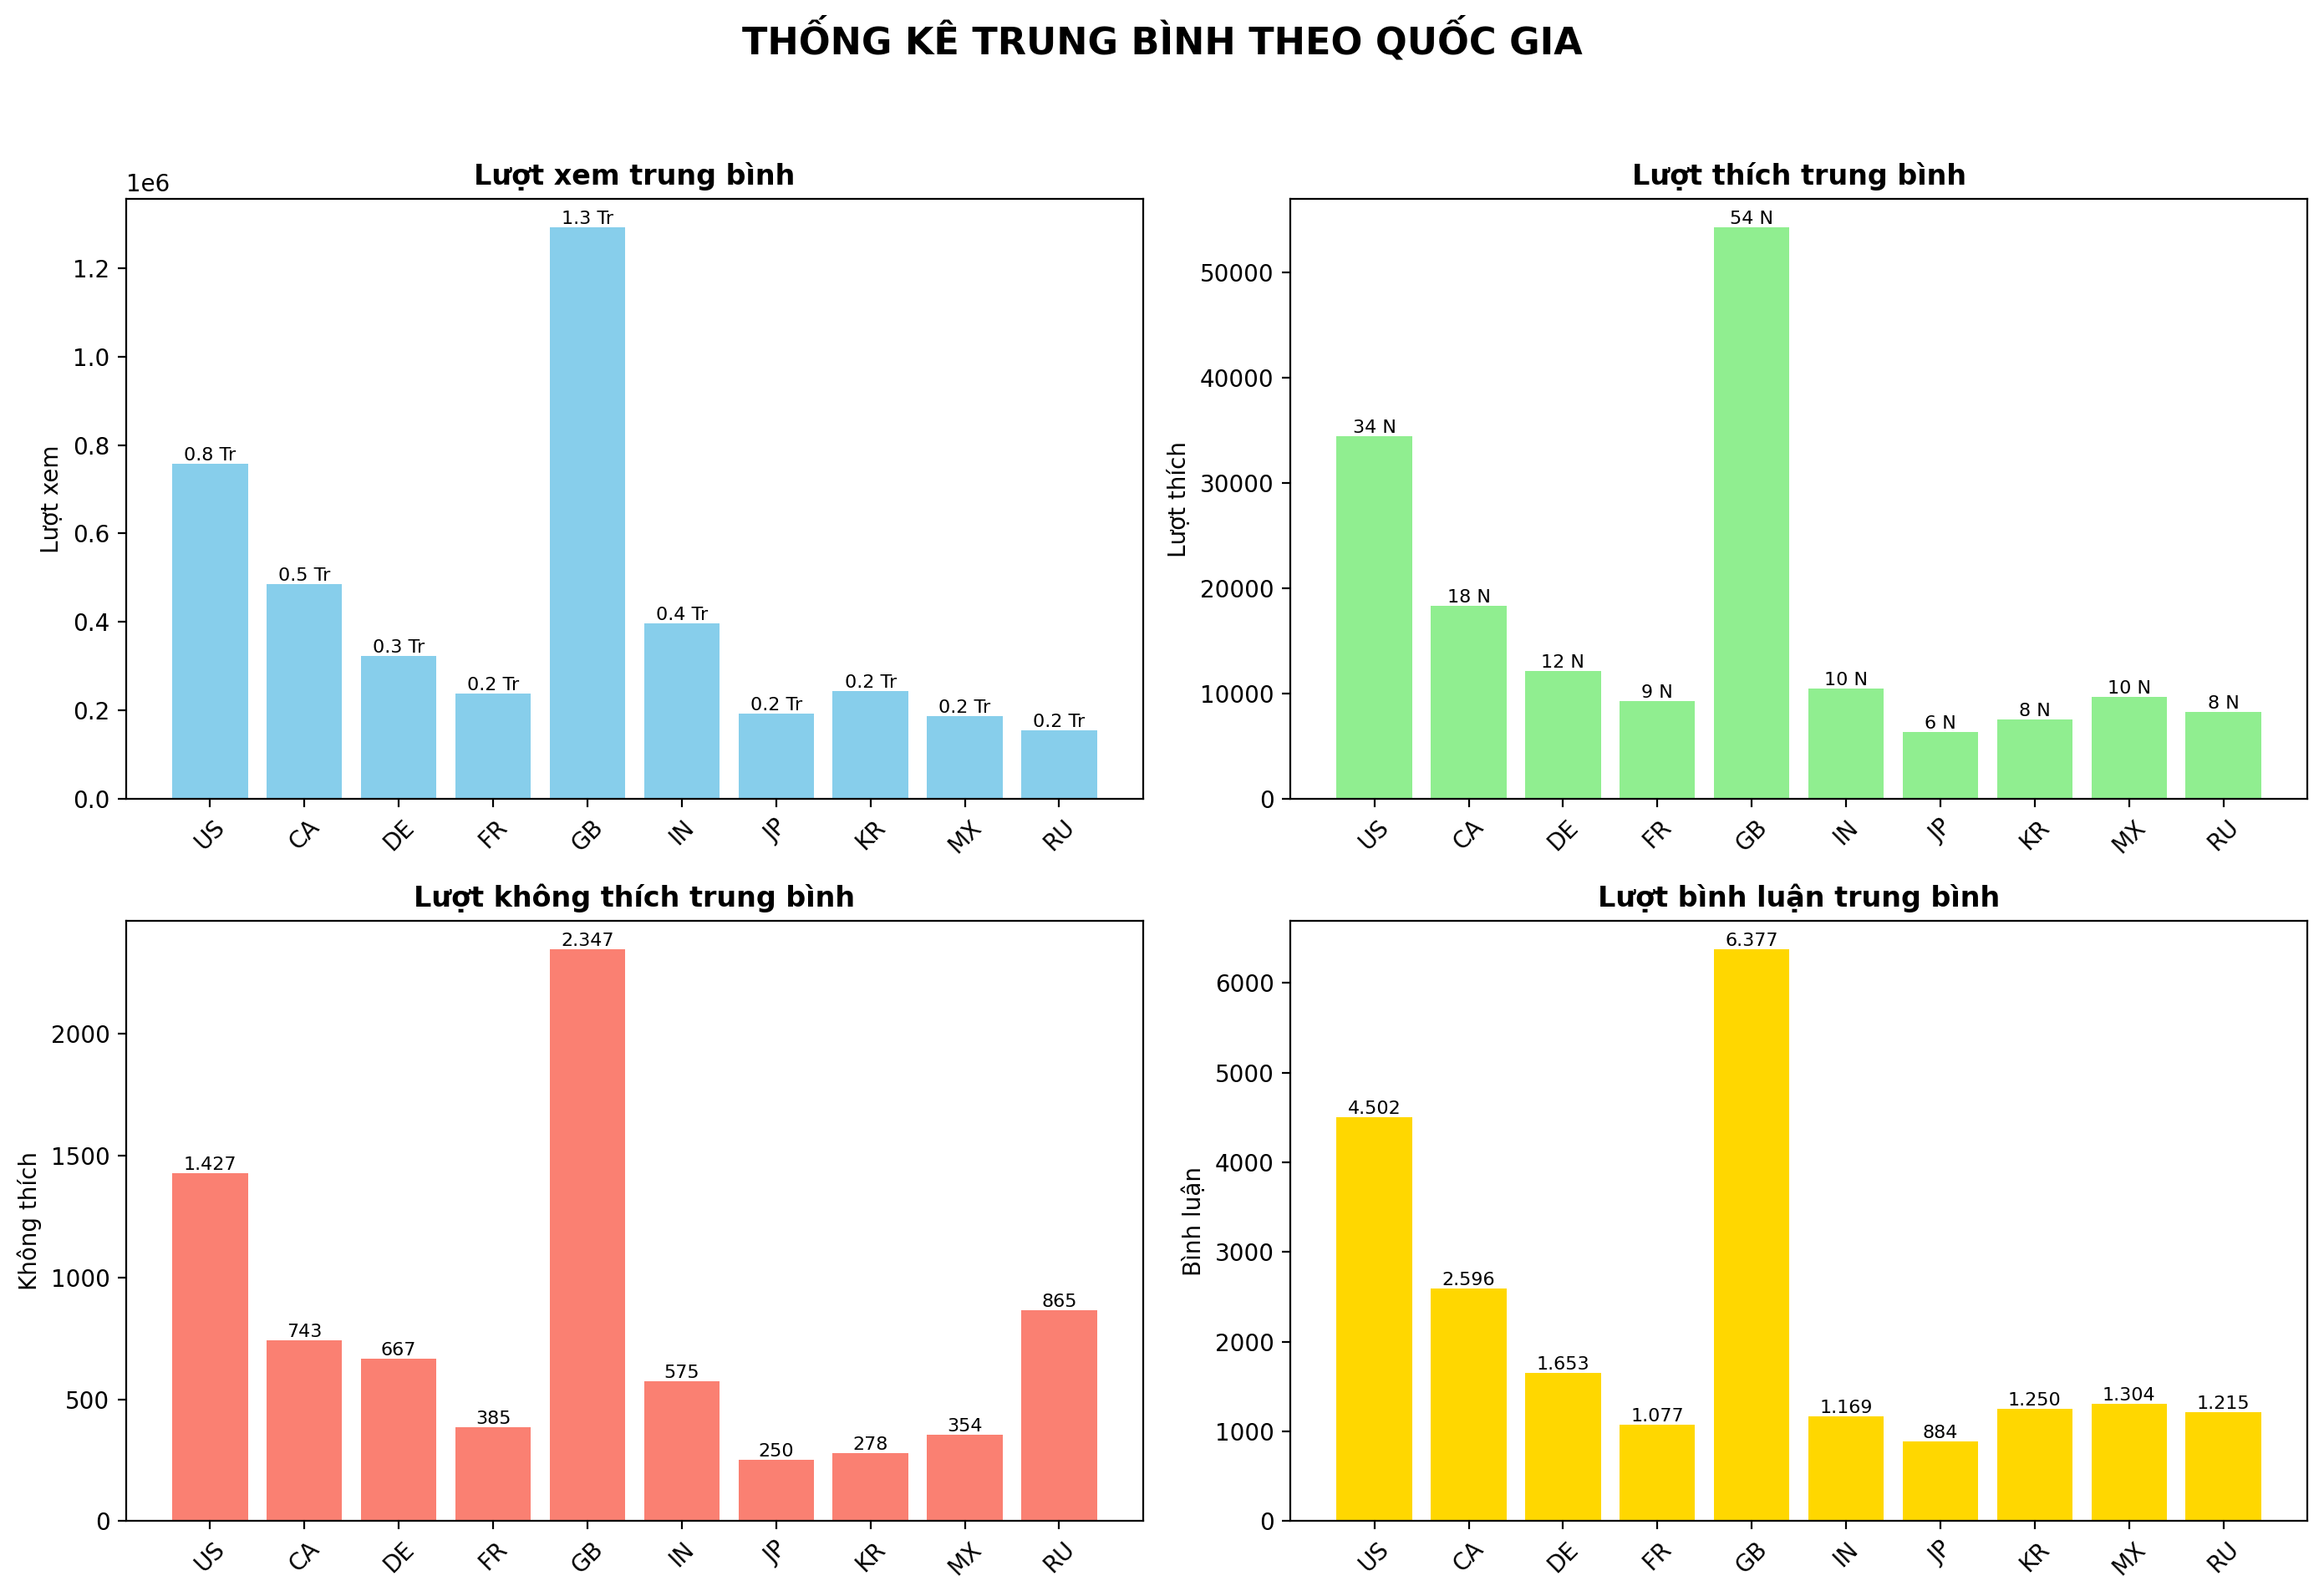

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette('husl')

# Quốc gia cần phân tích
countries = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']

# Tổng hợp dữ liệu
summary = []

for country in countries:
    df = dataframes[country]
    avg_views = df['views'].mean()
    avg_likes = df['likes'].mean()
    avg_dislikes = df['dislikes'].mean()
    avg_comments = df['comment_count'].mean()
    total_videos = len(df)

    print(f"\n[{country}]")
    print(f"Số video: {total_videos:,}")
    print(f"Lượt xem TB: {avg_views:,.0f}")
    print(f"Lượt thích TB: {avg_likes:,.0f}")
    print(f"Lượt không thích TB: {avg_dislikes:,.0f}")
    print(f"Lượt bình luận TB: {avg_comments:,.0f}")

    summary.append({
        'Quốc gia': country,
        'Lượt xem TB': avg_views,
        'Lượt thích TB': avg_likes,
        'Lượt không thích TB': avg_dislikes,
        'Lượt bình luận TB': avg_comments,
        'Số video': total_videos
    })

# Tạo DataFrame tổng hợp
df_summary = pd.DataFrame(summary)

# Hiển thị bảng số liệu
print("\n" + "="*50)
print("BẢNG SỐ LIỆU TRUNG BÌNH THEO QUỐC GIA")
print("="*50)
print(df_summary.round(2).to_string(index=False))

# Vẽ biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('THỐNG KÊ TRUNG BÌNH THEO QUỐC GIA', fontsize=16, fontweight='bold')

def draw(ax, col, color, title, ylabel, fmt=None):
    bars = ax.bar(df_summary['Quốc gia'], df_summary[col], color=color)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        val = bar.get_height()
        label = fmt(val) if fmt else f'{val:,.0f}'.replace(',', '.')
        ax.text(bar.get_x() + bar.get_width()/2, val, label, ha='center', va='bottom', fontsize=8)

# Vẽ các biểu đồ với nhãn tiếng Việt
draw(axes[0, 0], 'Lượt xem TB', 'skyblue', 'Lượt xem trung bình', 'Lượt xem', lambda x: f'{x/1e6:.1f} Tr')
draw(axes[0, 1], 'Lượt thích TB', 'lightgreen', 'Lượt thích trung bình', 'Lượt thích', lambda x: f'{x/1e3:.0f} N')
draw(axes[1, 0], 'Lượt không thích TB', 'salmon', 'Lượt không thích trung bình', 'Không thích')
draw(axes[1, 1], 'Lượt bình luận TB', 'gold', 'Lượt bình luận trung bình', 'Bình luận')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Chừa chỗ cho tiêu đề
plt.show()


## Tổng quan

Biểu đồ cho thấy mức độ tương tác với video trending khá khác biệt giữa các quốc gia. Anh và Mỹ nổi bật với lượt xem, lượt thích và bình luận cao – cho thấy người dùng tại đây rất tích cực tương tác.
## So sánh giữa các quốc gia

- Anh dẫn đầu về lượt xem (1.3 triệu) và bình luận, phản ánh sức hút mạnh của nội dung tại đây.

- Mỹ theo sát với lượt thích và bình luận cao, chứng tỏ cộng đồng người dùng năng động.

- Ấn Độ có lượt không thích cao nhất – có thể do nội dung gây tranh cãi nhiều hơn.

- Nhật, Hàn, Pháp có lượng tương tác khá thấp, có thể do thói quen ít like/bình luận của người xem.

## Theo vùng địa lý

Châu Âu nổi bật với nhiều quốc gia có mức tương tác tốt.

Bắc Mỹ phân hóa rõ: Mỹ rất cao, Canada trung bình.

Châu Á cho thấy sự đa dạng: Ấn Độ mạnh về số liệu, Nhật và Hàn trầm lặng hơn.

## Kết luận

Mỗi quốc gia có phong cách tiêu dùng nội dung khác nhau. Điều này tạo nên bức tranh phong phú cho YouTube toàn cầu và là gợi ý tốt cho các nhà sáng tạo khi muốn mở rộng tầm ảnh hưởng.

## **Trần Minh Thuận**

### **Question 3**: Top 7 kênh YouTube có số lượng video thịnh hành nhiều nhất trên toàn cầu

Phân tích để nhận diện những nhà sáng tạo/kênh có khả năng tạo ra nội dung trending một cách nhất quán và hiệu quả nhất.


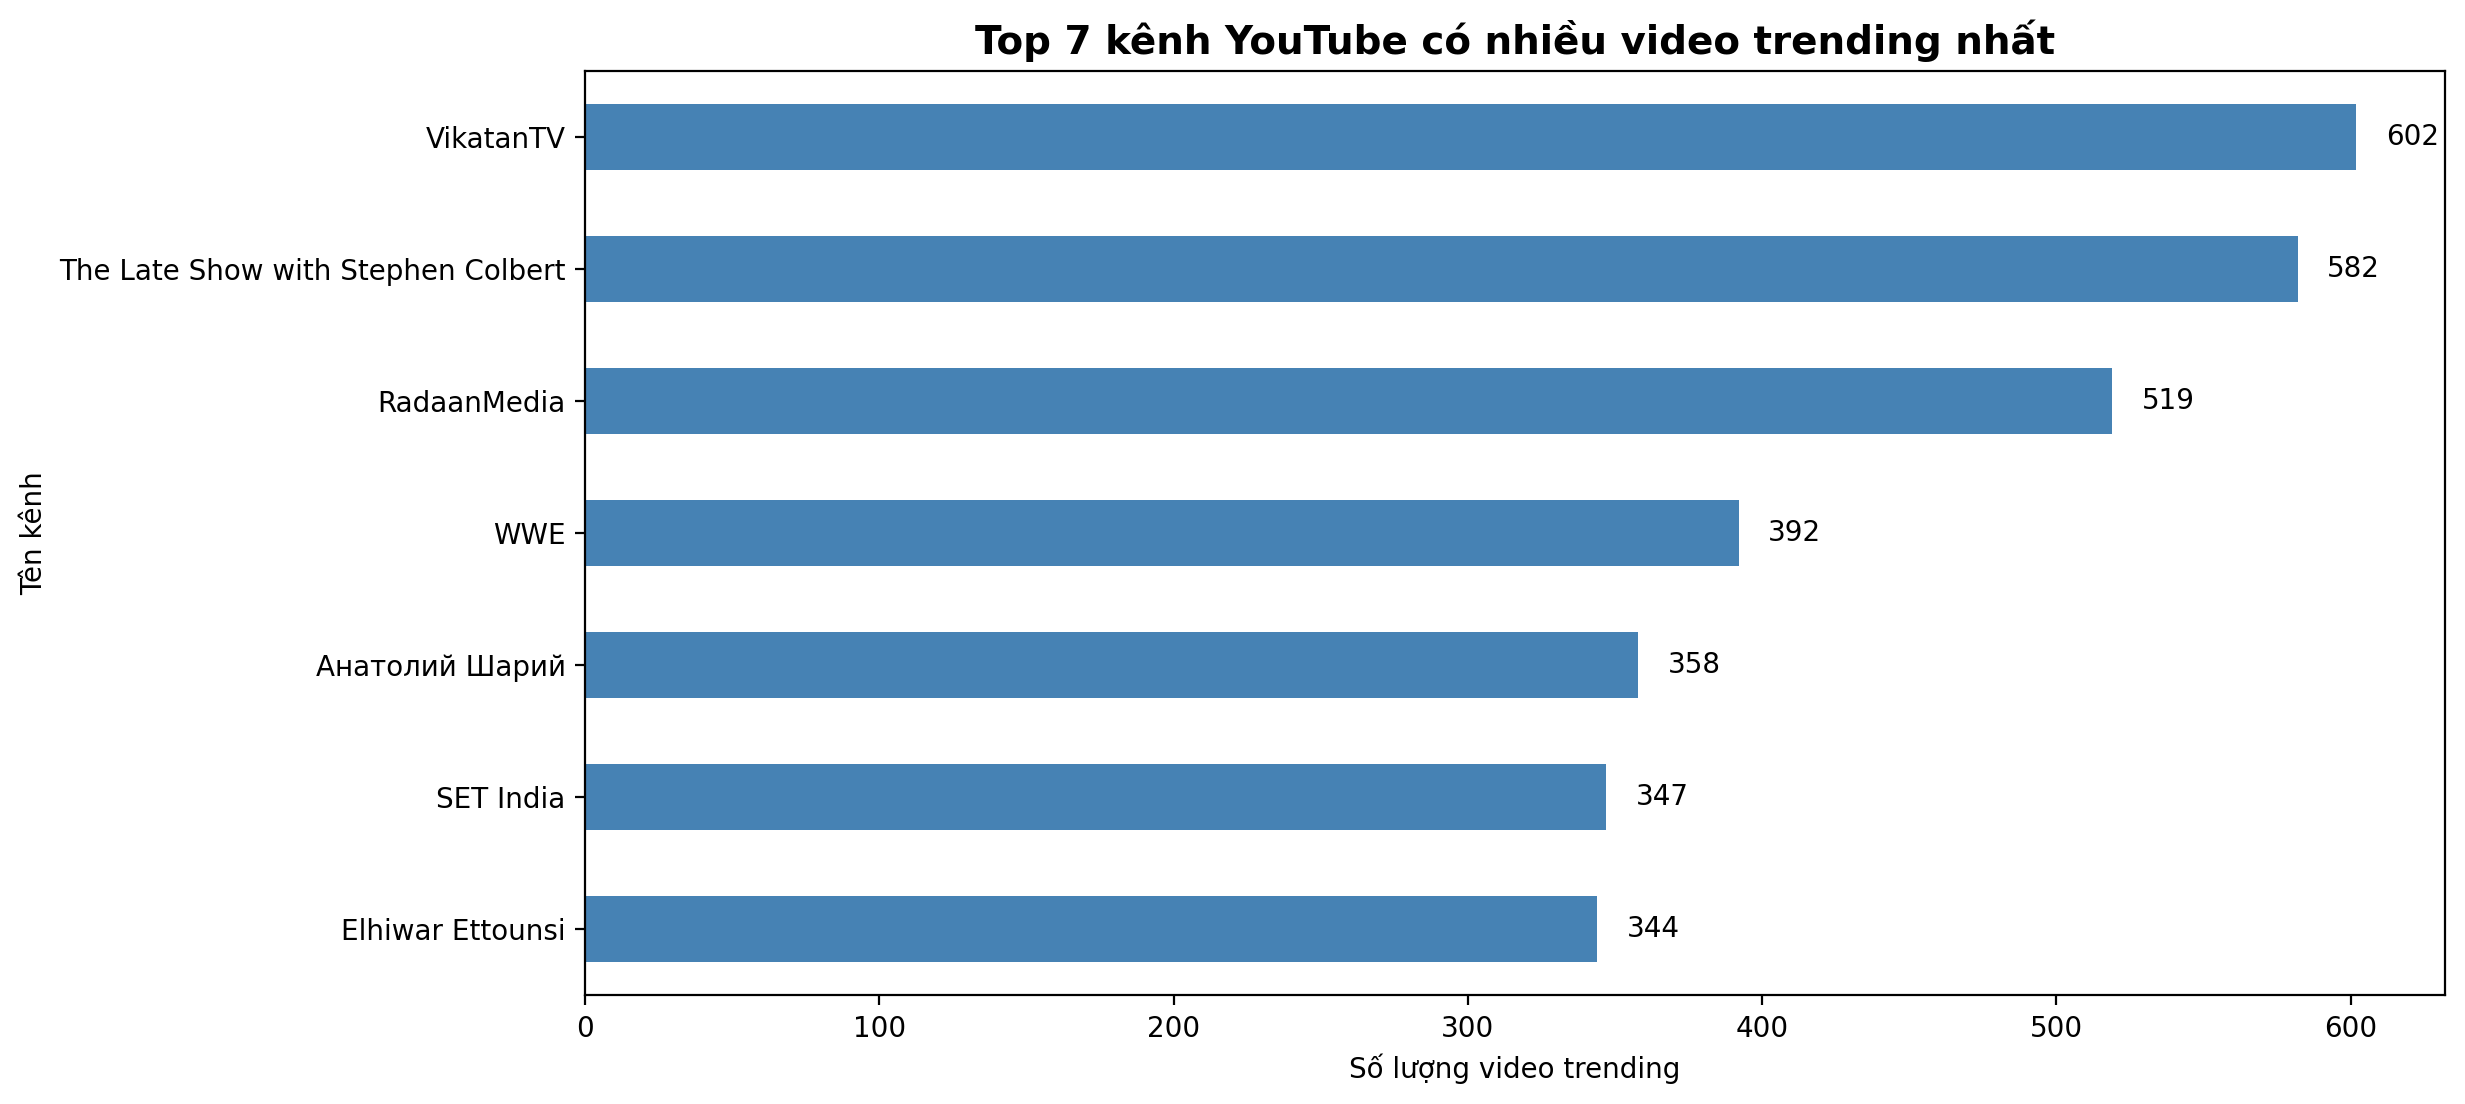

In [26]:
# Top 5 kênh có nhiều video trending nhất
top_channels = combined_df['channel_title'].value_counts().head(7)

plt.figure(figsize=(12, 6))
# [::-1] để đảo ngược thứ tự cột trong biểu đồ ngang
top_channels[::-1].plot(kind='barh', color='steelblue')

for i, v in enumerate(top_channels[::-1]):
    plt.text(v + 10, i, f'{v:,}', color='black', va='center', fontsize=10)

plt.title('Top 7 kênh YouTube có nhiều video trending nhất', fontsize=14, fontweight='bold')
plt.xlabel('Số lượng video trending')
plt.ylabel('Tên kênh')
plt.show()

## **Trần Minh Thuận**

### **Question 4**: Vẽ biểu đồ thể hiện thể loại nội dung được ưa chuộng của từng quốc gia

Phân tích phân phối các thể loại video giữa các quốc gia để thấy rõ sự khác biệt trong xu hướng nội dung và sự tương đồng giữa các khu vực. Phân tích này sử dụng thông tin từ tiêu đề video để phân loại nội dung.


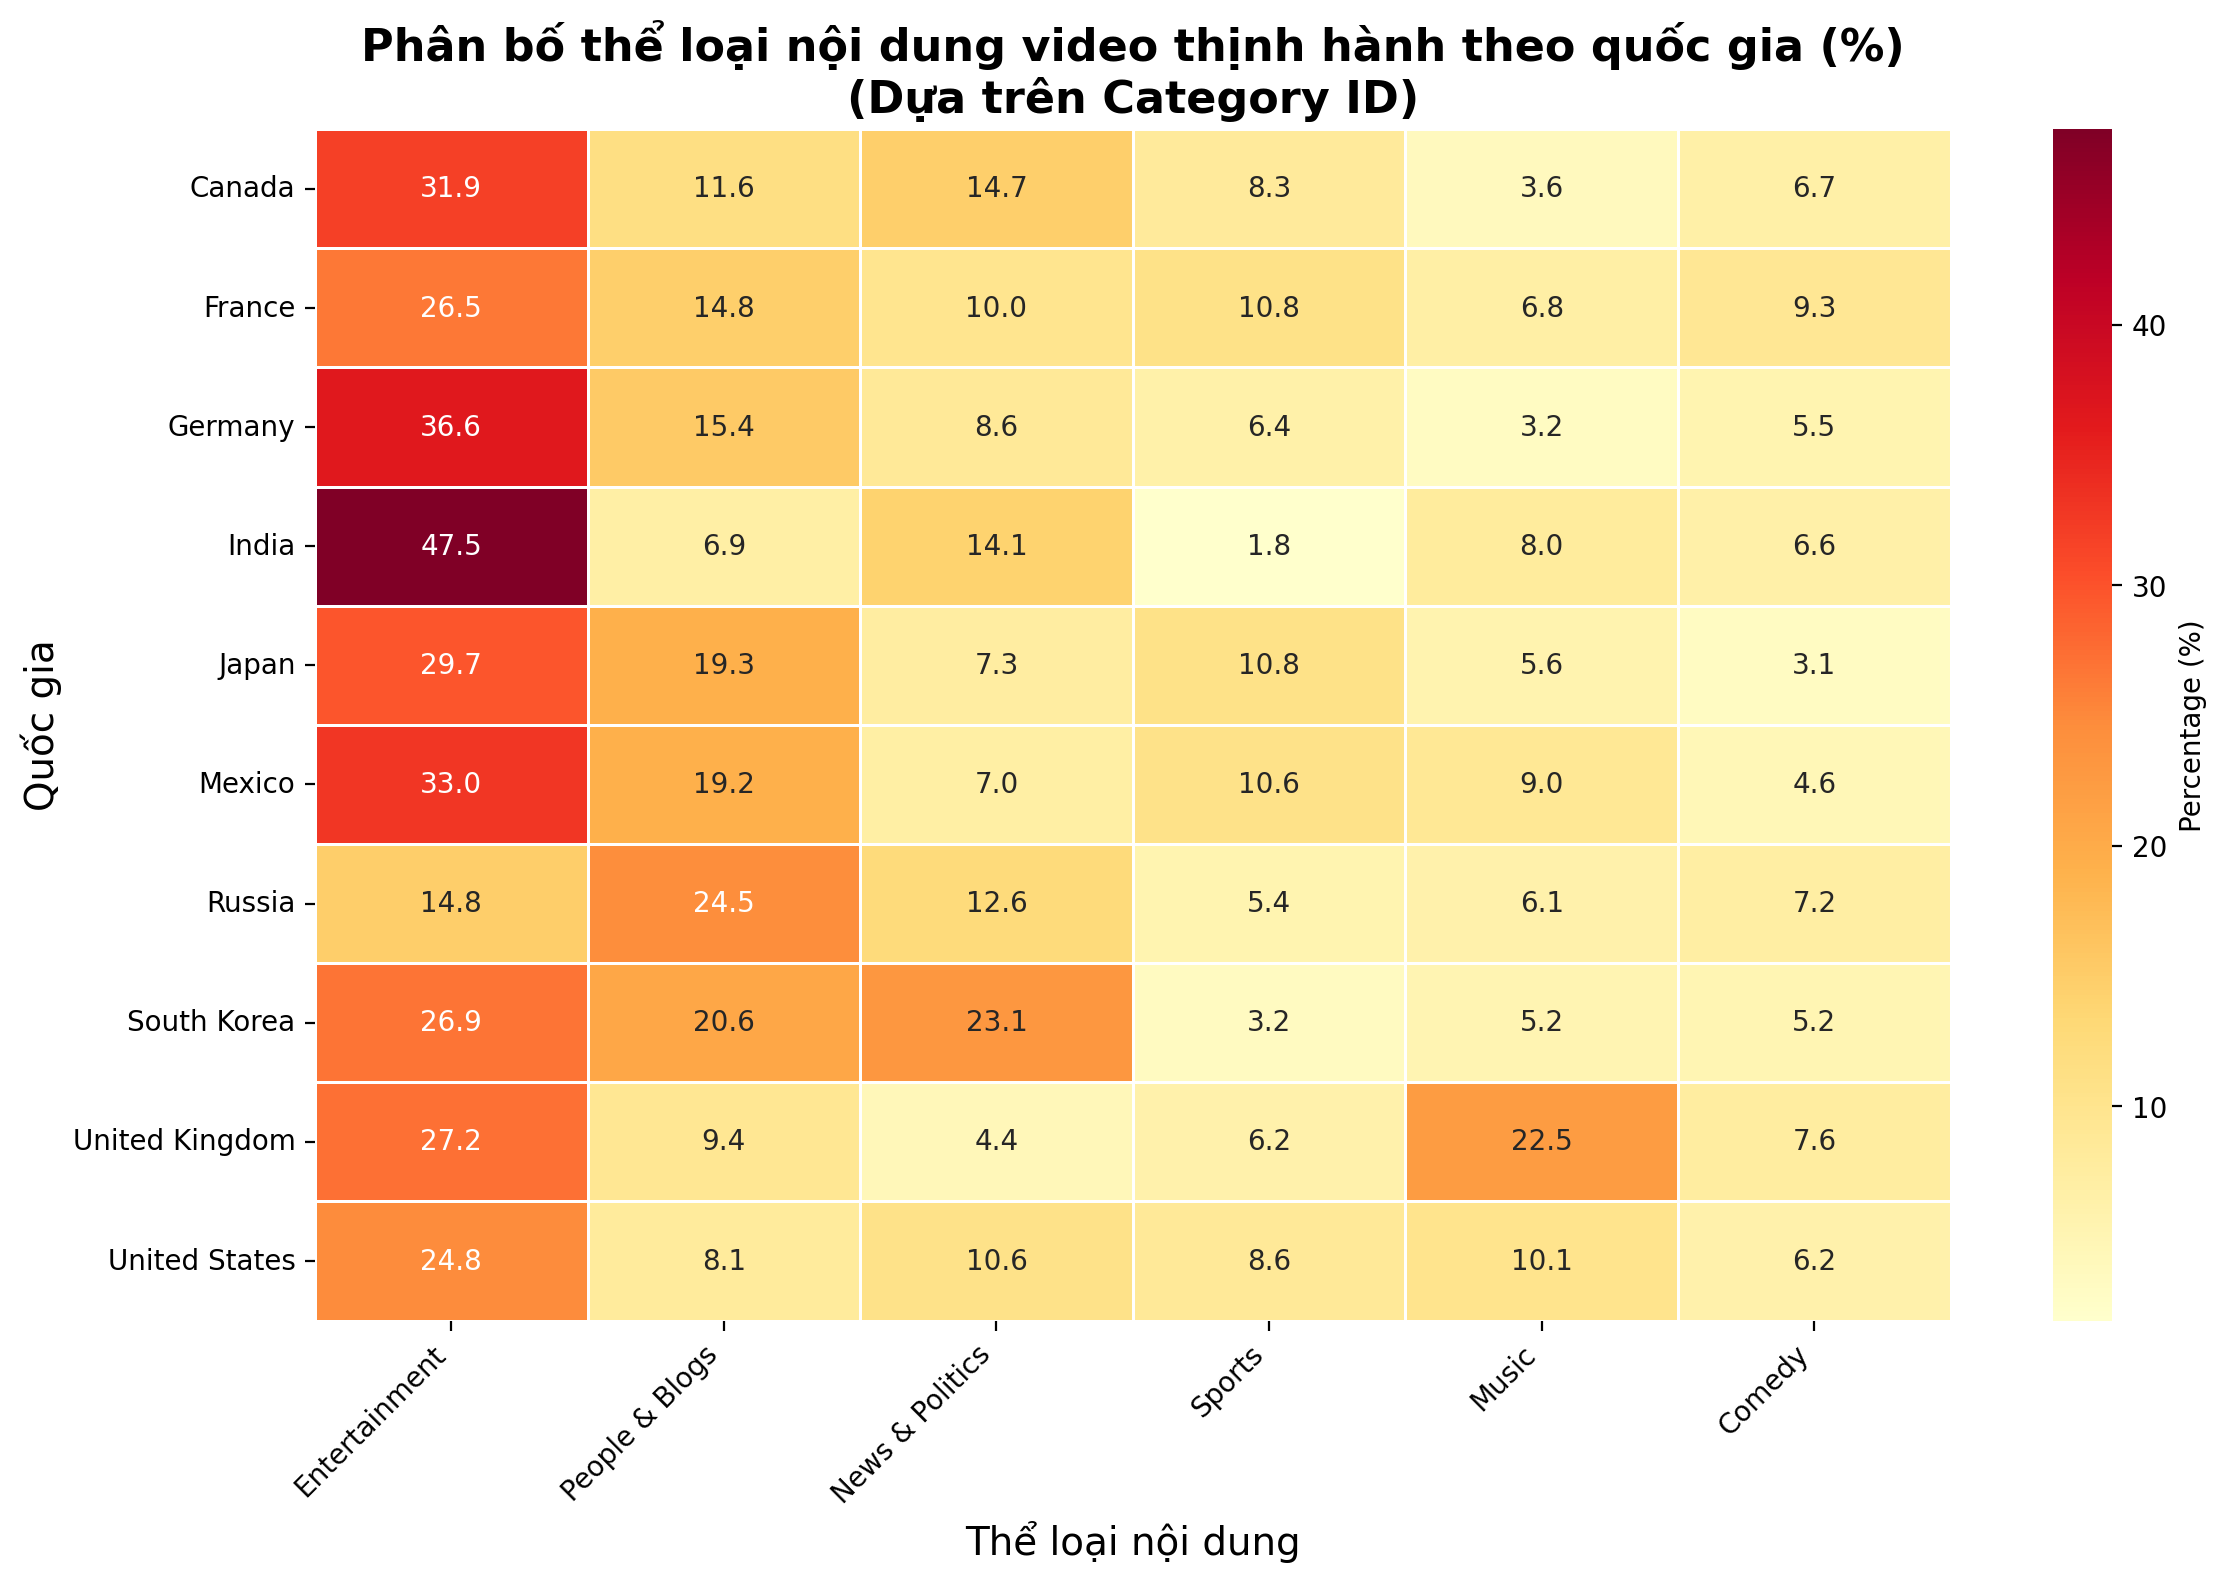

In [27]:
# Create a mapping of category_id to category names
# http://stackoverflow.com/questions/17698040/ddg#35877512
category_mapping = {
    1: 'Film & Animation',
    2: 'Autos & Vehicles', 
    10: 'Music',
    15: 'Pets & Animals',
    17: 'Sports',
    18: 'Short Movies',
    19: 'Travel & Events',
    20: 'Gaming',
    21: 'Videoblogging',
    22: 'People & Blogs',
    23: 'Comedy',
    24: 'Entertainment',
    25: 'News & Politics',
    26: 'Howto & Style',
    27: 'Education',
    28: 'Science & Technology',
    29: 'Nonprofits & Activism',
    30: 'Movies',
    31: 'Anime/Animation',
    32: 'Action/Adventure',
    33: 'Classics',
    34: 'Comedy',
    35: 'Documentary',
    36: 'Drama',
    37: 'Family',
    38: 'Foreign',
    39: 'Horror',
    40: 'Sci-Fi/Fantasy',
    41: 'Thriller',
    42: 'Shorts',
    43: 'Shows',
    44: 'Trailers'
}

# Add country name to combined_df for analysis
combined_df['country_code'] = ''
for country_code, df_country in dataframes.items():
    mask = combined_df['video_id'].isin(df_country['video_id'])
    combined_df.loc[mask, 'country_code'] = country_code

# Map country codes to country names
combined_df['country_name'] = combined_df['country_code'].map(country_names)

# Map category_id to category names
combined_df['category_name'] = combined_df['category_id'].map(category_mapping)

# Handle any unmapped categories
combined_df['category_name'] = combined_df['category_name'].fillna('Other')

# Create cross-tabulation of country vs category
content_by_country = pd.crosstab(combined_df['country_name'], combined_df['category_name'])

# Calculate percentage distribution for fair comparison between countries
content_pct = content_by_country.div(content_by_country.sum(axis=1), axis=0) * 100

# Select top categories to avoid overcrowding the heatmap
top_categories = content_by_country.sum().nlargest(6).index
content_pct_filtered = content_pct[top_categories]

# Create heatmap showing percentage distribution of content by country
plt.figure(figsize=(12, 8))
sns.heatmap(content_pct_filtered, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Percentage (%)'})
plt.title('Phân bố thể loại nội dung video thịnh hành theo quốc gia (%)\n(Dựa trên Category ID)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Quốc gia', fontsize=14)
plt.xlabel('Thể loại nội dung', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Nhận xét từ biểu đồ heatmap phân bố nội dung:

Dựa trên phân tích 207,148 video từ 10 quốc gia với 18 thể loại khác nhau, ta có những phát hiện thú vị:

#### **1. Xu hướng toàn cầu**
- **Entertainment** là thể loại thống trị (29.2% tổng số video), phổ biến ở hầu hết các quốc gia
- **People & Blogs** đứng thứ 2 (17.1%), cho thấy xu hướng cá nhân hóa nội dung mạnh mẽ
- **News & Politics** chiếm 11.3%, phản ánh nhu cầu thông tin cao của người xem

#### **2. Đặc trưng riêng biệt theo vùng**

**Nhóm châu Á:**
- **Ấn Độ**: Nổi bật với Entertainment cao nhất (47.5%), cho thấy nhu cầu giải trí lớn
- **Hàn Quốc**: Cân bằng giữa Entertainment (26.9%) và News & Politics (23.1%), phản ánh quan tâm chính trị cao
- **Nhật Bản**: Tập trung Entertainment (29.7%) và People & Blogs (19.3%)

**Nhóm châu Âu:**
- **Đức**: Dẫn đầu về Entertainment (36.6%) và People & Blogs (15.4%)
- **Pháp**: Cân bằng giữa Entertainment (26.5%), People & Blogs (14.8%) và Sports (10.8%)
- **Anh**: Đặc biệt với Music cao (22.5%), chỉ sau Entertainment (27.2%)

**Nhóm Bắc Mỹ:**
- **Canada**: Phân bố đều với Entertainment (31.9%) và quan tâm tin tức cao (14.7%)
- **Mỹ**: Cân bằng Entertainment (24.8%), News & Politics (10.6%) và Music (10.1%)

**Nhóm đặc biệt:**
- **Nga**: Duy nhất có People & Blogs dẫn đầu (24.5%), cho thấy văn hóa chia sẻ cá nhân mạnh
- **Mexico**: Entertainment cao (33.0%) với People & Blogs phát triển (19.2%)

#### **3. Insights chiến lược cho content creator**

**Thị trường toàn cầu**: Tập trung vào Entertainment và People & Blogs để có охват rộng nhất

**Thị trường từng khu vực**:
- **Châu Á**: Đầu tư vào Entertainment chất lượng cao
- **Châu Âu**: Kết hợp Entertainment với Sports và Music  
- **Bắc Mỹ**: Cân bằng giữa giải trí và thông tin
- **Nga**: Tận dụng xu hướng vlog/personal content mạnh mẽ

Sự đa dạng này phản ánh khác biệt văn hóa sâu sắc và mở ra cơ hội tối ưu nội dung theo từng thị trường cụ thể.

##### Hoàng Văn Đức

    Question 5: Vẽ biểu đồ cột thể hiện số lượng video thịnh hành theo giờ đăng trong ngày

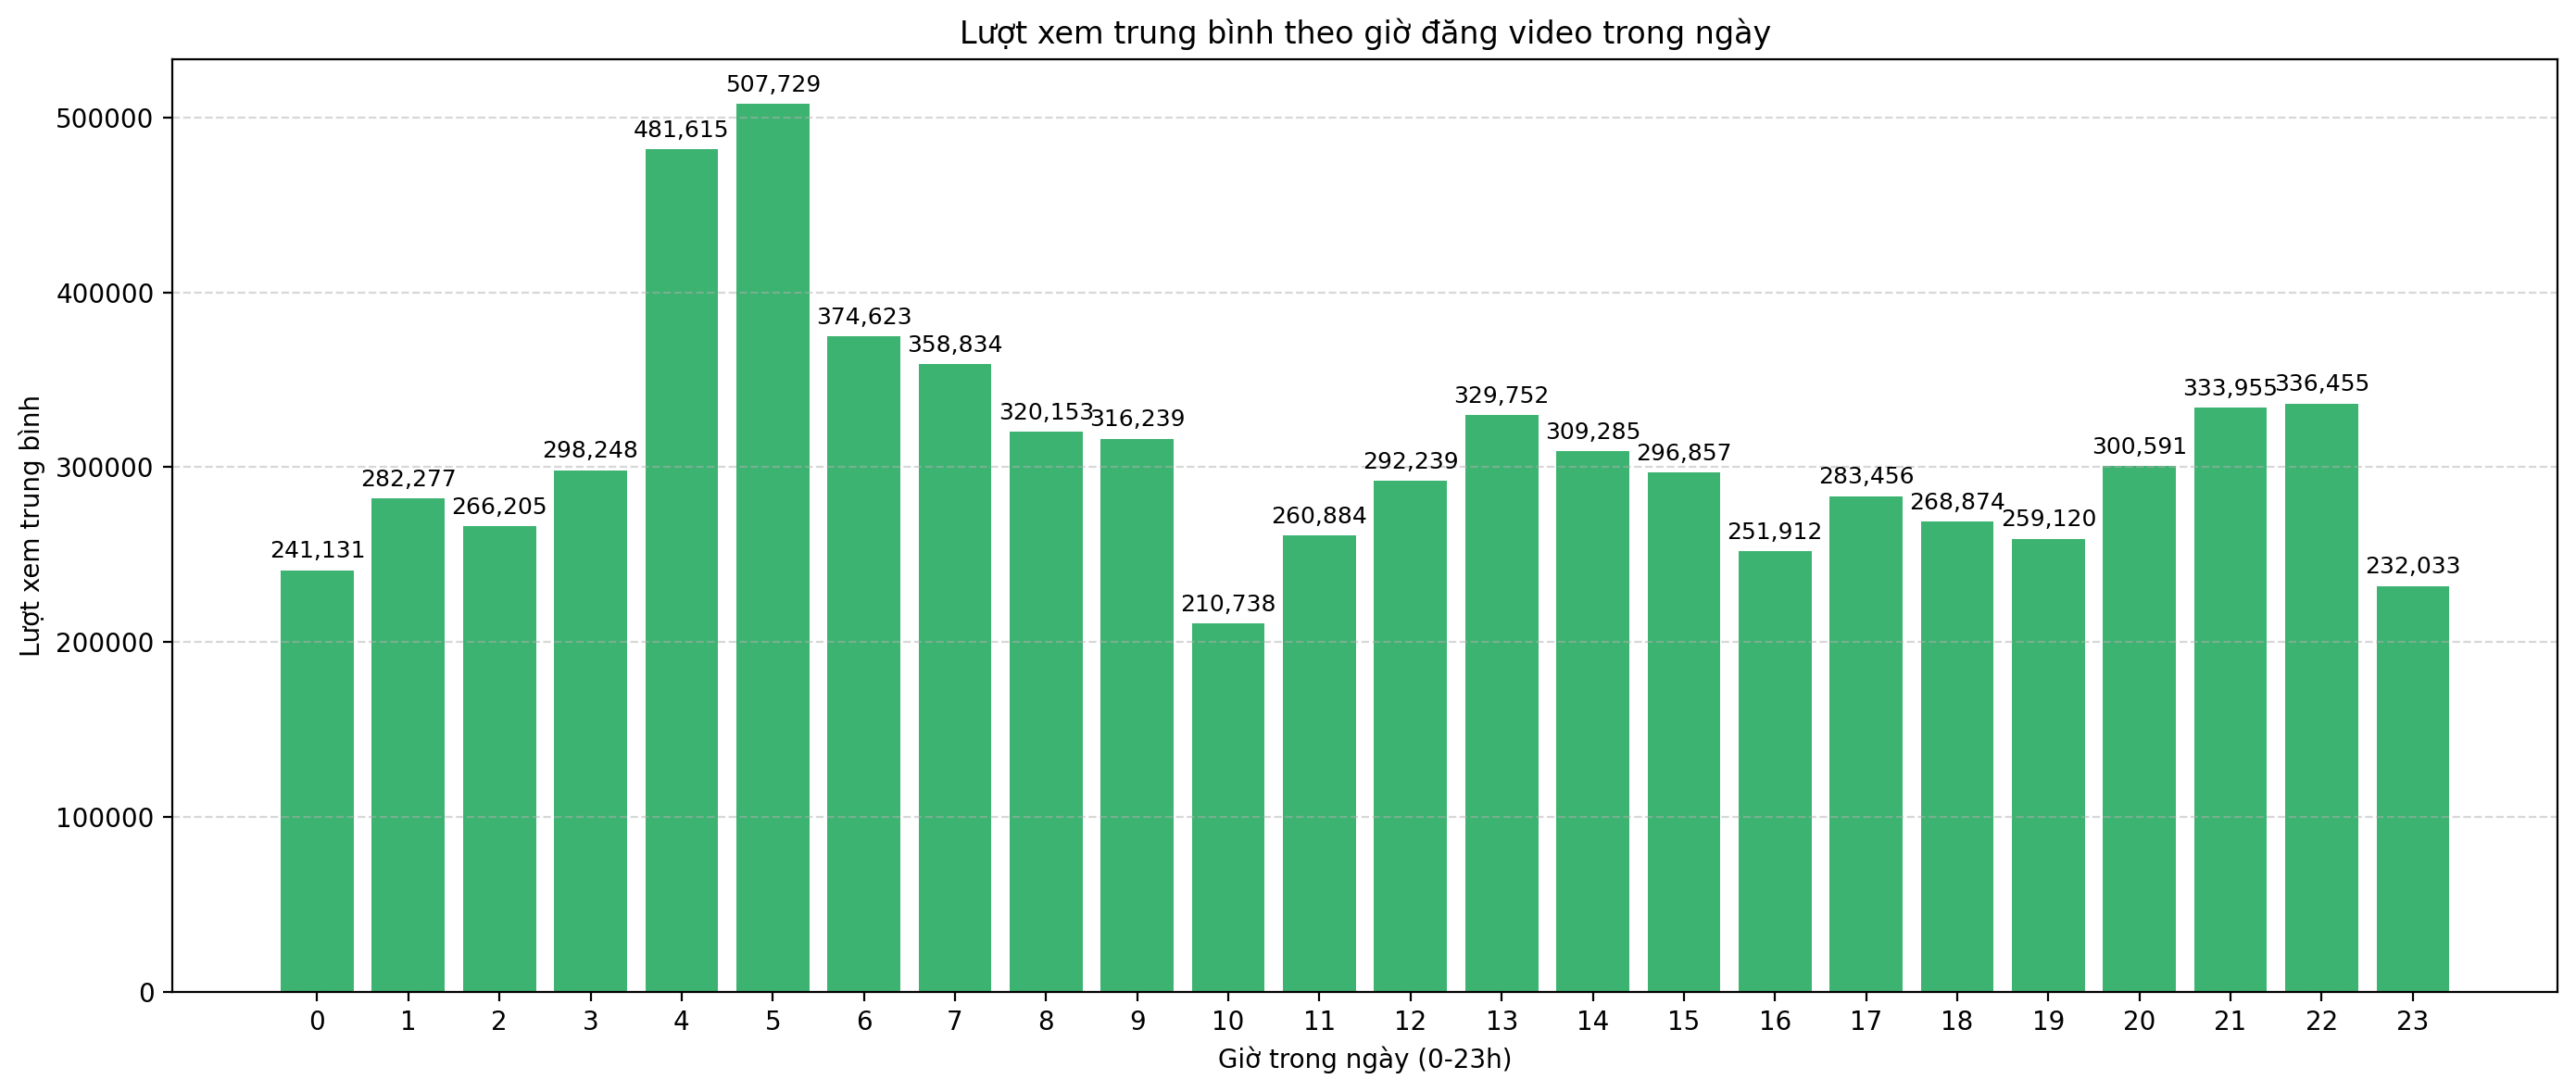

In [ ]:
# Lọc bỏ các dòng thiếu dữ liệu cần thiết
df_analysis = combined_df.dropna(subset=['publish_time', 'views']).copy()

# Tạo cột giờ (hour) từ publish_time
## lieu cai nayy su dung theo gio hay gio bat dau phat ra de lay so lieu ca ngay
df_analysis['publish_hour'] = df_analysis['publish_time'].dt.hour

# Nhóm theo giờ và tính trung bình lượt xem
views_by_hour = df_analysis.groupby('publish_hour')['views'].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
bars = plt.bar(views_by_hour['publish_hour'], views_by_hour['views'], color='mediumseagreen')

# Thêm số liệu cụ thể trên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:,.0f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # dịch lên trên
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# Giao diện biểu đồ
plt.xticks(range(0, 24))  # đảm bảo đủ 24 giờ
plt.title('Lượt xem trung bình theo giờ đăng video trong ngày')
plt.xlabel('Giờ trong ngày (0-23h) UTC-0')
plt.ylabel('Lượt xem trung bình')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Phân tích xu hướng đăng video theo giờ và hiệu suất

### 📊 Kết quả chính từ biểu đồ

**Lượt xem thấp nhất:** 10h sáng (~210k lượt xem)  
**Lượt xem cao nhất:** 5h sáng (~507k lượt xem)

---

### 🎯 Giải thích hiện tượng

#### **Tại sao 5h sáng lại hiệu quả nhất?**

YouTube phân phối video dựa trên **tín hiệu tương tác ban đầu** (đặc biệt là lượt xem và thời gian giữ chân). Vào 5h sáng:

- **Lượng người dùng rảnh cao:** Người dậy sớm, múi giờ khác nhau
- **Cạnh tranh thấp:** Ít kênh đăng video cùng thời điểm  
- **Phản hồi tích cực:** Người xem dễ tương tác → thuật toán đánh giá "có tiềm năng trending"

#### **Tại sao 10h sáng lại kém hiệu quả?**

- **Người dùng bận rộn:** Giờ đi học, đi làm
- **Cạnh tranh khốc liệt:** Phải cạnh tranh với nhiều video đăng sau đó
- **Tương tác thấp:** Ít người nhấn xem → thuật toán đánh giá "không trending"

---

### 💡 Insights quan trọng

> **YouTube cần tín hiệu tốt trong 30 phút - 2 giờ đầu sau khi đăng**

Nhiều creator tưởng "giờ hành chính" sẽ tốt hơn, nhưng thực tế thuật toán cần **phản hồi ngay lập tức** để quyết định phân phối.

---

### 🚀 Gợi ý tối ưu cho Content Creator

#### **1. Chọn khung giờ vàng**
- **5h-6h sáng:** Tối ưu nhất cho tích lũy tín hiệu
- **20h-22h:** Thời gian phụ tốt (không quá sớm, không quá muộn)

#### **2. Chiến lược dài hạn**
- **Duy trì lịch đăng:** Giúp người xem quen với thời gian
- **Thumbnail + tiêu đề hấp dẫn:** Tối đa hóa CTR ngay từ đầu
- **Tạo thói quen:** Người xem biết khi nào có video mới

#### **3. Tận dụng thuật toán**
- **30 phút đầu quyết định:** Tập trung promotion trong khung giờ này